In [92]:
import numpy as np
import scipy
from qutip import *
from numba import jit, njit

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import plot
import plotly.graph_objs as go

import sys

Let's consider a simple paradigmatic model for a molecule. A two-level system coupled to a single harmonic oscillator in the so-called polaron frame. This model is the paradigm of an optomechanical description of a molecular electronic transition coupled to a vibrational mode.
The Hamiltonian is given by
$H = H_0 + H_D$,
where
$H_0 = \Delta \hat{\sigma}^{\dag}\hat{\sigma} + \omega_V \hat{b}^{\dag}\hat{b}$, and $H_D=\Omega_R(\hat{\sigma} e^{-\eta(\hat{b}-\hat{b}^{\dag})} + {\rm h.c.} )$.

In [112]:
#all frequencies in GHz
gamma_rad = 2*np.pi * 0.1    #radiative decay rate
gamma_deph = 2*np.pi * 0.      #dephasing rate

gamma_v = 2*np.pi * 1.      #vibrational decay rate
om_v = 2*np.pi * 10         #vibrational frequency
n_th = .1                    #vibrational thermal population

eta = 0.1

Om_R = 2*np.pi * .1

Nvib = 10
sig = tensor( sigmam(), qeye(Nvib))
b = tensor(qeye(2), destroy(Nvib))
IDq = tensor(qeye(2), qeye(Nvib))
sig_p = sig * tensor(qeye(2), displace(Nvib, eta))

vDelta_opt = 2*np.pi * np.linspace(-40,40,300)
Fluo = np.zeros(len(vDelta_opt))
for nD, Delta_opt in enumerate(vDelta_opt):
    H0 = om_v*b.dag()*b + Delta_opt*sig.dag()*sig
    HD = Om_R * ( sig_p + sig_p.dag() )

    c_jumps = [ gamma_rad**.5*sig_p, gamma_deph**.5*sig.dag()*sig, (gamma_v*(1+n_th))**.5*b, (gamma_v*(n_th))**.5*b.dag() ]

    rho_ss = steadystate(H0+HD, c_jumps)

    Fluo[nD] = expect(sig.dag()*sig, rho_ss)

In [113]:
Gam_plus = 2*np.pi * .1
c_jumps = [ gamma_rad**.5*sig_p, gamma_deph**.5*sig.dag()*sig, (gamma_v*(1+n_th))**.5*b, (gamma_v*(n_th))**.5*b.dag(), Gam_plus**.5*sig.dag() ]
H0 = om_v*b.dag()*b + 0*sig.dag()*sig
rho_ss_off = steadystate(H0, c_jumps)

taulist = np.linspace(0, 10., 5000)
C1 = correlation_2op_1t(H0, rho_ss_off, taulist, c_jumps, sig_p.dag(), sig_p, solver='me')# reverse=True)
wlist, S1 = spectrum_correlation_fft(taulist, C1)

(-40.0, 40.0)

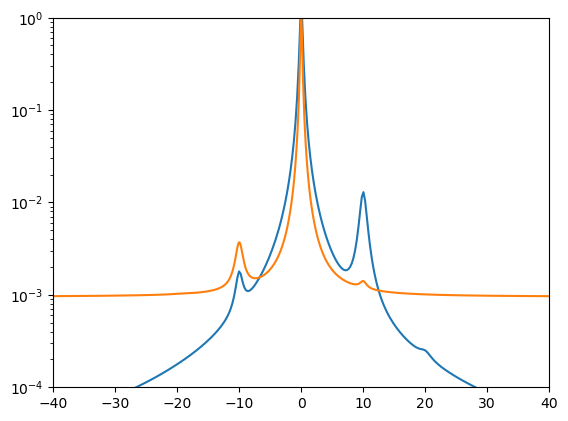

In [114]:
plt.plot(-vDelta_opt/(2*np.pi),Fluo/np.amax(Fluo))
plt.plot(wlist/(2*np.pi), (S1)/np.amax(S1) )
plt.yscale('log')
plt.ylim(1e-4,1e0)
plt.xlim(-40,40)